In [2]:
# Do not change this cell
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
num_classes = 4
num_features = 2
random_seed = 1

# Create dataset
X, y = make_blobs(n_samples=10000, n_features=num_features, centers=num_classes, 
                  cluster_std=1.5, random_state=random_seed)

# Convert to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# Split dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [7]:
X, y = make_blobs(n_samples=10000, n_features=num_features, centers=num_classes, 
                  cluster_std=1.5, random_state=random_seed)
torch.from_numpy(X).type(torch.float)
torch.from_numpy(y).type(torch.LongTensor)

tensor([0, 3, 1,  ..., 1, 3, 0])

In [2]:
#note we only have two features
#our output should be an integer 0-3
#input size is 2 because we have two features, output_size is 4 is because we have 4 classes
testing1 = 8
class SimpleModel(nn.Module):
    def __init__(self, input_size = 2, output_size = 4):
        super().__init__()    
        self.fc_1 = nn.Linear(input_size, testing1)
        self.fc_2 = nn.Linear(testing1,output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
    def forward(self, x):
        x = self.softmax(self.fc_2(self.relu(self.fc_1(x))))
        return x
        

In [3]:
def train_step(model, X_train, y_train, loss_fn, optimizer, device):
    model.train()
    #move to device
    X_train, y_train = X_train.to(device), y_train.to(device)

    #to loss function CE in this case 
    y_logit = model(X_train)
    loss = loss_fn(y_logit, y_train)

    #compute accuracy
    na, y_pred = torch.max(y_logit, 1) #softmax first arg not needed 
    correct = torch.eq(y_pred, y_train).sum().item() #taken from slides
    train_acc = (correct / len(y_pred)) * 100
    
    # Update step from slides
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, train_acc
    
    #returns train loss and train accuracy ONLY AFTER ONE EPOCH HENCE STEP

In [4]:
def evaluation_step(model, X_test, y_test, loss_fn, device):
    #move to device
    with torch.no_grad():
        X_test, y_test = X_test.to(device), y_test.to(device)
    
        #Compute your loss function
        y_test_logit = model(X_test)
        loss = loss_fn(y_test_logit, y_test)
        
        #compute accuracy
        na, y_pred_test = torch.max(y_test_logit, 1) 
        correct = torch.eq(y_pred_test, y_test).sum().item() #taken from slides
        test_acc = (correct / len(y_pred_test)) * 100
        #returns train loss and train accruacy of model after it has been trained 
    return loss,test_acc

In [5]:
num_epochs = 200
def train_simple_model(X_train, y_train, X_test, y_test, random_seed):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(random_seed) # do not change this
    simple_model = SimpleModel().to(device)
    loss_func = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(simple_model.parameters(), lr = 0.1)
    simple_model.train()

    train_acc_list = []
    train_loss_list = []
    test_acc_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        loss, acc = train_step(simple_model, X_train, y_train, loss_func, opt, device)
        train_acc_list.append(acc)
        train_loss_list.append(loss.item())
        
        test_loss, test_acc = evaluation_step(simple_model, X_test, y_test, loss_func, device)
        test_loss_list.append(test_loss.item())
        test_acc_list.append(test_acc)
        
        if epoch % 50 == 0:
            print(f"Epoch: {epoch}, Train Loss: {loss}, Train Accuracy: {acc}")
            print(f"\t   Test loss: {test_loss}, Test Accuracy {test_acc}\n")

    return simple_model, train_loss_list, train_acc_list, test_loss_list, test_acc_list

In [6]:
# TODO: plot accuracy curves
def plot_accuracy_performance(train_accuracies, test_accuracies):
    epochs = np.linspace(1, len(train_accuracies), len(train_accuracies))
    plt.plot(epochs,train_accuracies, label = "Train Accuracy", c= "red")
    plt.plot(epochs,test_accuracies, label = "Test Accuracy", c = "blue")
    plt.xlabel("Epoch Number"); plt.ylabel("Accuracy %"); plt.title("Accuracy in Train vs Test Sets")
    plt.legend()

In [7]:
# TODO: plot loss curves
def plot_loss_performance(train_losses, test_losses):
    epochs = np.linspace(1, len(train_losses), len(test_losses))
    plt.plot(epochs,train_losses, label = "Train Set Losses", c= "red")
    plt.plot(epochs,test_losses, label = "Test Set Losses", c = "blue")
    plt.xlabel("Epoch Number"); plt.ylabel("Cross Entropy Loss"); plt.title("Cross Entropy in Train vs Test Sets")
    plt.legend()

In [8]:
def plot_decision_boundary(model, X_train, y_train):
    #code ripped from slides
    col1 = X_train[:,0]
    col2 = X_train[:,1]
    
    min_x1 = col1.min()  #this is to find the "Grid length"
    max_x1 = col1.max()
    
    min_x2 = col2.min() #this is to find the grid height, for bounds of decision boundaries
    max_x2 = col2.max()
    
    arange_step = .05  #this is saying how far apart we want our coordinate points to be 
    
    xx, yy = np.meshgrid(np.arange(min_x1, max_x1, arange_step),
                         np.arange(min_x2, max_x2, arange_step)) #imagine this as creating the coordinate grid
    
    grid_data = np.c_[xx.ravel(), yy.ravel()]  #Ravel is just np.flatten but for higher dimensional matrices
    
    grid_data = torch.from_numpy(grid_data).type(torch.float).to("cuda") #in our case we need to predict these features 
    model.eval()                                                         #so we have to make it a tensor

    #this chunk get's us prediction for the grid
    with torch.inference_mode():
        y_logit = model(grid_data)
        y_predict = torch.max(y_logit,1)[1].cpu().numpy() #indexing at one bc torch.max returns 2 things
    preds = y_predict.reshape(xx.shape) 

    plt.scatter(col1,col2, c = y_train)
    plt.contourf(xx, yy, preds, alpha = .25)
    plt.title("Decision Boundaries For Training Set")

In [9]:
# Do not change this cell
model, train_losses, train_accuracies, test_losses, test_accuracies\
    = train_simple_model(X_train, y_train, X_test, y_test, random_seed)

C:\Users\Andy Ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 0, Train Loss: 1.4023476839065552, Train Accuracy: 46.6625
	   Test loss: 1.310768723487854, Test Accuracy 46.400000000000006

Epoch: 50, Train Loss: 0.8563985228538513, Train Accuracy: 89.4
	   Test loss: 0.8442380428314209, Test Accuracy 91.60000000000001

Epoch: 100, Train Loss: 0.8267236351966858, Train Accuracy: 91.7875
	   Test loss: 0.8242908716201782, Test Accuracy 91.85

Epoch: 150, Train Loss: 0.825472354888916, Train Accuracy: 91.825
	   Test loss: 0.8230129480361938, Test Accuracy 91.8



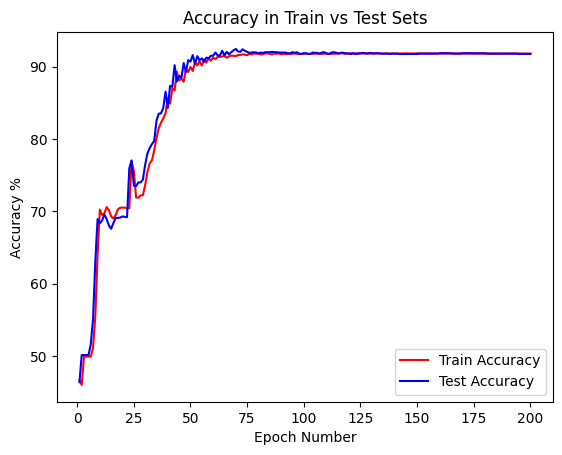

In [10]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, test_accuracies)

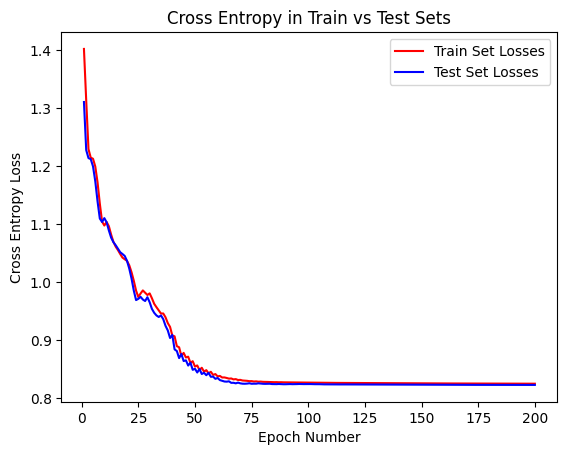

In [11]:
# Do not change this cell
plot_loss_performance(train_losses, test_losses)

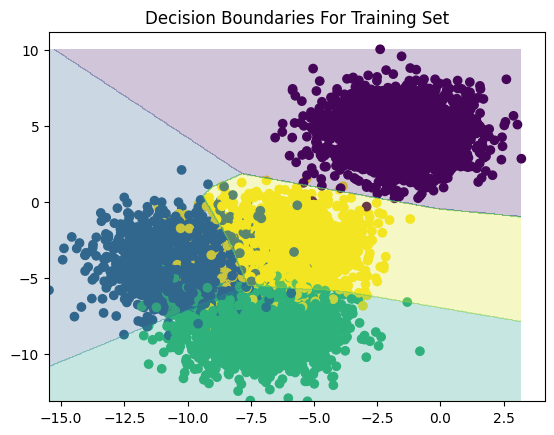

In [12]:
# Do not change this cell
plot_decision_boundary(model, X_train, y_train)